authors:  Alessandro Bonetti (15855902) Bowen Ma (12960780) Olga Milovanova(12879436)

In [ ]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from tqdm import tqdm
from scipy.stats import skew, kurtosis
#import dataframe_image as dfi
import jinja2
from statsmodels.distributions.empirical_distribution import ECDF

# Normality tests
from scipy.stats import jarque_bera, shapiro, anderson, cramervonmises
from scipy.stats import norm, zscore
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import omni_normtest # Doornik-Hansen

### Question 1

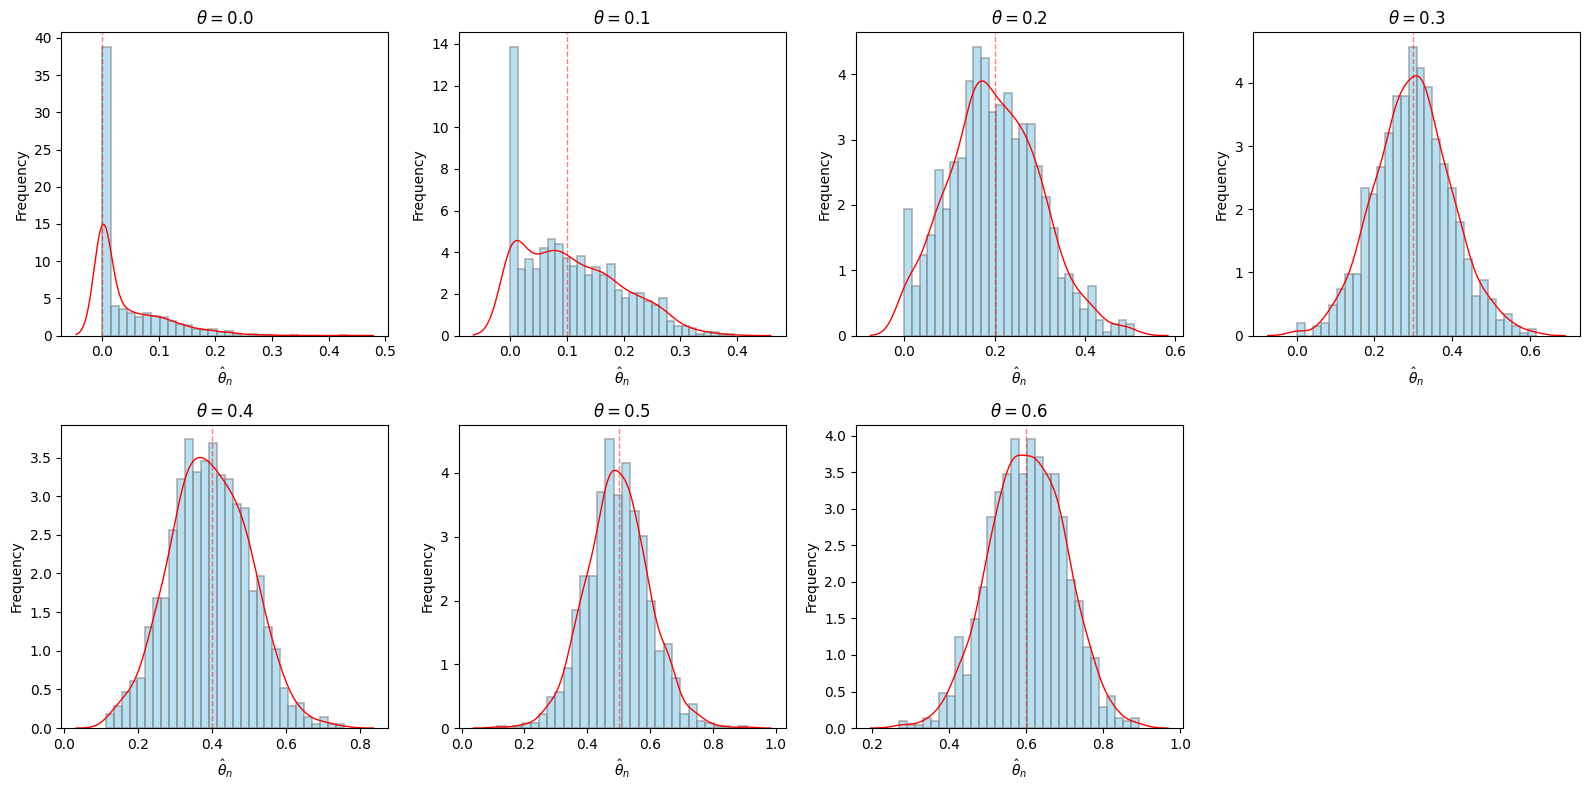

In [ ]:
# For reproducibility
np.random.seed(42)

# Simulation set-up
n = 100                                    # Sample sizes
sim = 1000                                 # Number of simulations
theta_values = np.arange(0.0, 0.7, 0.1)    # Theta values

# Plot set-up
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, theta in enumerate(theta_values):
    estimates = [] # MC estimates

    for _ in range(sim):
        epsilon = np.random.normal(0, 1, n) # Generate errors
        y = theta + epsilon
        y_bar = np.mean(y)                  # Sample mean
        theta_hat = max(0, y_bar)           # QMLE
        estimates.append(theta_hat)

    # Plot the histogram of theta_hat
    ax = axes[i]
    ax.hist(
        estimates,
        bins=30,
        density=True,
        alpha=0.6,
        color='skyblue',
        edgecolor='grey',   # Add black edges to bars
        linewidth=1.2,      # Width of the bar lines
        label='Histogram'
    )
    ax.axvline(x=theta, color='r', linestyle='--', linewidth=1, alpha=0.5, label=r'$\theta$')
    sns.kdeplot(estimates, ax=ax, color="red", linewidth=1, label="KDE")
    ax.set_title(r'$\theta = {:.1f}$'.format(theta))
    ax.set_xlabel(r'$\hat{\theta}_n$')
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for j in range(len(theta_values), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### Question 2

In [ ]:
from scipy.stats import jarque_bera, shapiro, anderson

# For reproducibility
np.random.seed(42)

# Parameters
theta_values = np.arange(0, 0.7, 0.1)    # Theta values
n_values = [100, 400]                    # Sample sizes
sim = 1000                               # Number of simulations
alpha = 0.05                             # Significance level

# Function for bootstrap test
def bootstrap_test(theta, n, alpha):
    epsilon = np.random.normal(0, 1, size=n)  # Generate errors
    y = theta + epsilon
    theta_hat = max(0, np.mean(y))            # QMLE

    # Bootstrap sample (m=n)
    theta_B = []
    for _ in range(n):
        epsilon_B = np.random.normal(0, 1, size=n)  # Generate bootstrap errors
        y_B = theta_hat + epsilon_B
        theta_B.append(max(0, np.mean(y_B)))

    # Test results
    test_results = {}
    test_results["Jarque-Bera"] = jarque_bera(theta_B).pvalue < alpha
    stat_AD, crit_value_AD, _ = anderson(theta_B, dist='norm')
    test_results["Anderson-Darling"] = stat_AD > crit_value_AD[2]  # 5% critical value
    test_results["Shapiro-Wilk"] = shapiro(theta_B).pvalue < alpha
    test_results["Lilliefors"] = lilliefors(theta_B, dist='norm')[1] < alpha
    test_results["Doornik-Hansen"] = omni_normtest(theta_B)[1] < alpha

    return test_results

# Simulation
results = []

for n in n_values:
    for theta in theta_values:
        rejections = {test: 0 for test in [
            "Jarque-Bera", "Anderson-Darling", "Shapiro-Wilk", "Lilliefors", "Doornik-Hansen"
        ]}

        # Perform simulations
        for _ in tqdm(range(sim), desc=f"n={n}, theta={theta}"):
            test_results = bootstrap_test(theta, n, alpha)
            for test, rejected in test_results.items():
                rejections[test] += rejected

        # Store results
        results.append({
            "Sample size": n,
            "Theta": theta,
            "Jarque-Bera": rejections["Jarque-Bera"] / sim,
            "Anderson-Darling": rejections["Anderson-Darling"] / sim,
            "Shapiro-Wilk": rejections["Shapiro-Wilk"] / sim,
            "Lilliefors": rejections["Lilliefors"] / sim,
            "Doornik-Hansen": rejections["Doornik-Hansen"] / sim,
        })

n=400, theta=0.6000000000000001: 100%|██████████| 1000/1000 [00:20<00:00, 48.60it/s]


In [ ]:
# Create a table
results_df = pd.DataFrame(results)

# Convert rejection frequencies to percentages
for col in ["Jarque-Bera", "Anderson-Darling", "Shapiro-Wilk", "Lilliefors", "Doornik-Hansen"]:
    results_df[col] = (results_df[col] * 100).round(2)

# Reshape results into a cleaner table format
summary_df = results_df.melt(
    id_vars=["Sample size", "Theta"],
    var_name="Test",
    value_name="Rejection frequency at 5%"
)

# Pivot table for better layout
summary_table = summary_df.pivot_table(
    index=["Sample size", "Theta"],
    columns="Test",
    values="Rejection frequency at 5%"
).reset_index()

# Sort the table for readability
summary_table.sort_values(by=["Sample size", "Theta"], inplace=True)

summary_table = summary_table.reset_index(drop=True)

# Style the DataFrame
def highlight_rejection(val):
    if val > 50:
        return 'background-color: lightcoral;'  # Light red
    elif val > 25:
        return 'background-color: lightyellow;'  # Light yellow
    return ''

# Rounding theta for layout
summary_table['Theta'] = summary_table['Theta'].round(2).astype(str)

# Adjust the DataFrame to make 'Sample size' appear only once
summary_table_grouped = summary_table.set_index(["Sample size", "Theta"])

# Style the table with grouped index
styled_summary = (
    summary_table_grouped.style
    .applymap(highlight_rejection, subset=summary_table_grouped.columns)
    .set_table_styles([
        {"selector": "table", "props": [("border", "2px solid black"), ("border-collapse", "collapse")]},
        {"selector": "th", "props": [("border", "2px solid black"), ("padding", "5px")]},
        {"selector": "td", "props": [("border", "2px solid black"), ("padding", "5px")]}
    ])
    .format(precision=2)
)

# Display the styled table
styled_summary


<ipython-input-24-0f53ff24eaea>:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary_table_grouped.style


### Question 3

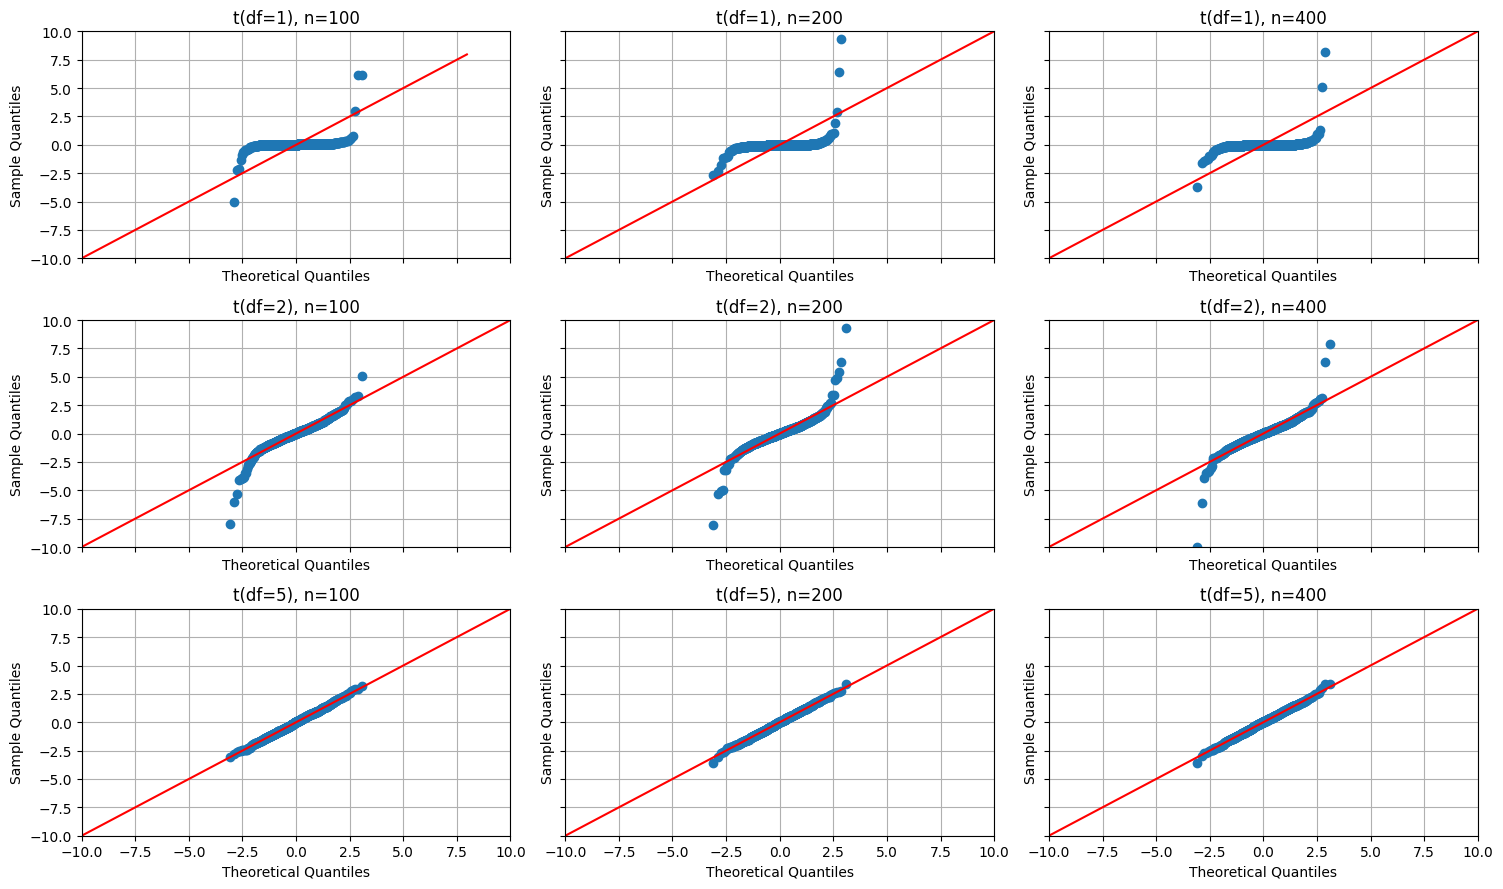

In [ ]:
# For reproducibility
np.random.seed(42)

# Parameters
n_values = [100, 200, 400]     # Sample sizes
dof_values = [1, 2, 5]         # Degrees of freedom
sim = 1000                     # Number of simulations

# Plot set-up
fig, axes = plt.subplots(
    nrows=len(dof_values),
    ncols=len(n_values),
    figsize=(15, 9),
    sharex=True,  # Share x-axis
    sharey=True   # Share y-axis
)
axes = axes.ravel()
plot_idx = 0

for v in dof_values:
    for n in n_values:
        sample_means = []

        for _ in range(sim):
            y = np.random.standard_t(df=v, size=n)
            theta_hat = np.mean(y)
            sample_means.append(theta_hat)

        # Create Q-Q plot against normal
        ax = axes[plot_idx]
        sm.qqplot(np.array(sample_means), line='45', ax=ax, fit=True)
        ax.set_title(f"t(df={v}), n={n}")

        # Set x and y limits
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

        # Add a grid
        ax.grid(True)

        plot_idx += 1

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Question 4

In [ ]:
# For reproducibility
np.random.seed(42)

# Parameters
n_values = [100, 200, 400]            # Sample sizes
v_values = [1, 2, 5]                  # Degrees of freedom for t-distribution
sim = 1000                            # Number of simulations
alpha = 0.05                          # Significance level

# Define m index mappings
m_calculations = {
    "n^(1/2)": lambda n: int(n ** 0.5),
    "n^(4/5)": lambda n: int(n ** 0.8),
    "n/2": lambda n: int(n / 2),
    "n": lambda n: n
}

# Function for infinite variance bootstrap testing
def infinite_variance_bootstrap(n, v, m, alpha):
    # Generate original sample
    epsilon = np.random.standard_t(df=v, size=n)  # Generate errors by using a t-distribution
    theta_hat = np.mean(epsilon)                  # Sample mean
    residuals = epsilon - theta_hat

    # Bootstrap sample (m bootstrap replications)
    bootstrap_means = []
    for _ in range(m):
        bootstrap_residuals = np.random.choice(residuals, size=n, replace=True)
        bootstrap_means.append(np.mean(theta_hat + bootstrap_residuals))

    # Perform the most powerful normality test (Shapiro-Wilk)
    test_statistic = shapiro(bootstrap_means).pvalue < alpha
    return test_statistic

results = []

# Simulation
for n in n_values:
    for v in v_values:
        for m_label, m_function in m_calculations.items():
            m = m_function(n)  # Calculate m using the corresponding function
            rejection_count = 0

            # Perform simulations
            for _ in tqdm(range(sim), desc=f"n={n}, v={v}, m={m_label}"):
                rejection_count += infinite_variance_bootstrap(n, v, m, alpha)

            # Store results
            results.append({
                "n": n,
                "v (df)": v,
                "m_label": m_label,  # Store descriptive m_label
                "m": m,              # Store the actual m value
                "Rejection Frequency": rejection_count / sim
            })


n=400, v=5, m=n: 100%|██████████| 1000/1000 [00:18<00:00, 54.49it/s]


In [ ]:
# Create a DataFrame from the results
MC_results_df = pd.DataFrame(results)

# Compute statistics (mean and rejection frequencies)
summary_df = MC_results_df.groupby(['n', 'v (df)','m_label', 'm']).agg(
    rejection_freq_5_percent=('Rejection Frequency', 'mean')
).reset_index()

# Convert rejection frequencies to percentages and round to the second decimal
summary_df['rejection_freq_5_percent'] = (summary_df['rejection_freq_5_percent'] * 100).round(2)

# Rename columns
summary_df.columns = [
    'Sample size', 'Degrees of freedom (v)', 'm_label', 'm', 'Rejection frequency at 5%'
]

# Set multilevel index
summary_df.set_index(['Sample size', 'Degrees of freedom (v)','m_label', 'm'], inplace=True)

# Sort the index for a clean layout
summary_df.sort_index(level=['Sample size', 'Degrees of freedom (v)','m_label', 'm'], inplace=True)

# Highlighting function for values
def highlight_rejection(val):
    if val > 50:
        return 'background-color: lightcoral;'  # Light red
    elif val > 25:
        return 'background-color: lightyellow;'  # Light yellow
    return ''

# Apply styling
styled_df = (summary_df
    .style
    .applymap(highlight_rejection, subset=['Rejection frequency at 5%'])
    .set_table_styles([
        {"selector": "table", "props": [("border", "2px solid black"), ("border-collapse", "collapse")]},
        {"selector": "th", "props": [("border", "2px solid black"), ("padding", "5px")]},
        {"selector": "td", "props": [("border", "2px solid black"), ("padding", "5px")]}
    ])
    .format(precision=2)  # Format all cells to 2 decimal places
)

# Display the styled DataFrame
styled_df


<ipython-input-27-6895d5a0c3ba>:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = (summary_df


### Question 5

In [ ]:
# --- SETTING AND FUNCTIONS ---

# --- Set random seed for reproducibility ---
np.random.seed(42)

# --- DGP ----
sample_sizes = [100, 200, 400] # possible sample sizes

# Parameters
c_array = [0, 50, 1000] # possible values for the numerator of pi
beta_array = np.linspace(-3,3,10) # possible values for beta
sigma_eps = 1
sigma_u = 1
sigma_z = 1
cov_eps_u = 0.7
cov_matrix_eps_u = [[sigma_eps**2, cov_eps_u], [cov_eps_u, sigma_u**2]]

# Define a function to generate the data
def generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u):
    # Generate epsilon and u with the specified covariance matrix
    eps, u = np.random.multivariate_normal([0, 0], cov_matrix_eps_u, n).T

    # Generate z
    z = np.random.normal(0, sigma_z, n)

    # Generate x
    x = c/np.sqrt(n) * z + u

    # Generate y
    y = beta*x + eps

    return y, x, z

# Define a function to estimate pi_hat and beta_hat
def two_sls(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Estimate beta_hat
    beta_hat = np.sum(x_hat*y)/np.sum(x_hat**2)

    # Compute residuals from 2nd stage regression
    eps_hat = y - beta_hat*x

    # Compute standard error of beta_hat
    s_2 = np.sum(eps_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(x_hat**2))  # standard error of 2SLS estimator
    # np.sqrt (s_2 * np.sum(z*z) / np.sum((z*x)**2)) this formula is equivalent, but gives numerical instability

    # Return fitted residuals
    return beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat

# --- Bootstrap procedure ---
# Define a function to run the bootstrap procedure
def bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat, boot_rep=None):

    if boot_rep is None:
        boot_rep = round(n**(4/5))  # default number of bootstrap replications

    pi = c / np.sqrt(n) # compute pi from c and n
    w = np.vstack((u_hat, eps_hat)).T  # make pairs

    beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped regression coefficient for beta_hat
    se_beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped standard error for beta_hat
    t_star = np.zeros(boot_rep)  # initialize array to store bootstrapped t-statistic

    for b in range(boot_rep):
        # resample bootstrap residuals from fitted residuals
        index = np.random.randint(n, size=n)  # select the indices
        w_star = np.copy(w[index,])  # resample the pairs
        u_star = w_star[:,0]
        eps_star = w_star[:,1]

        # Generate x_star
        x_star = pi_hat*z + u_star

        # Generate y_star
        y_star = beta_hat*x_star + eps_star

        # Generate bootstrapped estimates
        data = two_sls(y_star,x_star,z) # obtain bootstrap estimates using two_sls function
        beta_hat_star[b] = data[0] # store bootstrapped regression coefficient for beta_hat
        se_beta_hat_star[b] = data[4] # store bootstrapped standard error for beta_hat
        t_star[b] = np.sqrt(n) * (beta_hat_star[b] - beta_hat) # store (not standardized) bootstrapped t-statistic
        # t_star[b] = (beta_hat_star[b] - beta_hat) / se_beta_hat_star[b] # standardize and store bootstrapped t-statistic

        # APPROACH 2 - alternative with synthetic formula
        # t_star[b] = np.sum(z*eps_star) / np.sum(z*x_star) * se_beta_hat_star[b]

        # Debugging line
        # Print state of bootstrap procedure
        # print(f"completion of bootstrap: {(b / boot_rep) * 100:.2f}%")

    return t_star, beta_hat_star, se_beta_hat_star

In [ ]:
# --- MONTECARLO SIMULATION on original sample (without bootstrap) ---

# Set random seed for reproducibility
np.random.seed(42)

# We simulate the T-statistic
# for each combination of sample size, c for MC_rep times

# We choose a value of beta = 1.67 for illustration
beta_value = beta_array[7] # extract value of beta from beta_array

MC_rep = 1000 # number of MonteCarlo simulations
MC_results_sample = [] # store the results of the MonteCarlo simulation

inst_relevance = None

# Calculate the total number of iterations
total_iterations = len(sample_sizes) * len(c_array) * MC_rep
current_iteration = 0

# Loop over the combinations of sample size, c, and beta
for n in sample_sizes:

    for c in c_array:
        # label the instrument relevance
        if c == 0:
            inst_relevance = 'irrelevant'
        elif c == 50:
            inst_relevance = 'weak'
        elif c == 1000:
            inst_relevance = 'strong'


        for i in range(MC_rep):
            # Generate the data
            y, x, z = generate_data(n, c, beta_value, sigma_eps, sigma_u, sigma_z, cov_eps_u)

            # Draw the original sample and estimate the parameters
            beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

            # Compute the T-statistic
            t = np.sqrt(n) * (beta_hat - beta_value)

            # Store the results
            MC_results_sample.append({
                'n': n,
                'pi': c / (n**0.5),
                'instrument_relevance': inst_relevance,
                't_statistic': t
            }) # create a Dataframe indexed by n, pi=c/sqrt(n)

            # Update and print state of the simulation
            current_iteration += 1
            total_completion = (current_iteration / total_iterations) * 100
            print(f"Completion of Monte Carlo: {total_completion:.2f}%")

# Create a DataFrame to store the results
MC_results_sample_df = pd.DataFrame(MC_results_sample)

Output streaming troncato alle ultime 5000 righe.
Completion of Monte Carlo: 44.46%
Completion of Monte Carlo: 44.47%
Completion of Monte Carlo: 44.48%
Completion of Monte Carlo: 44.49%
Completion of Monte Carlo: 44.50%
Completion of Monte Carlo: 44.51%
Completion of Monte Carlo: 44.52%
Completion of Monte Carlo: 44.53%
Completion of Monte Carlo: 44.54%
Completion of Monte Carlo: 44.56%
Completion of Monte Carlo: 44.57%
Completion of Monte Carlo: 44.58%
Completion of Monte Carlo: 44.59%
Completion of Monte Carlo: 44.60%
Completion of Monte Carlo: 44.61%
Completion of Monte Carlo: 44.62%
Completion of Monte Carlo: 44.63%
Completion of Monte Carlo: 44.64%
Completion of Monte Carlo: 44.66%
Completion of Monte Carlo: 44.67%
Completion of Monte Carlo: 44.68%
Completion of Monte Carlo: 44.69%
Completion of Monte Carlo: 44.70%
Completion of Monte Carlo: 44.71%
Completion of Monte Carlo: 44.72%
Completion of Monte Carlo: 44.73%
Completion of Monte Carlo: 44.74%
Completion of Monte Carlo: 44.76

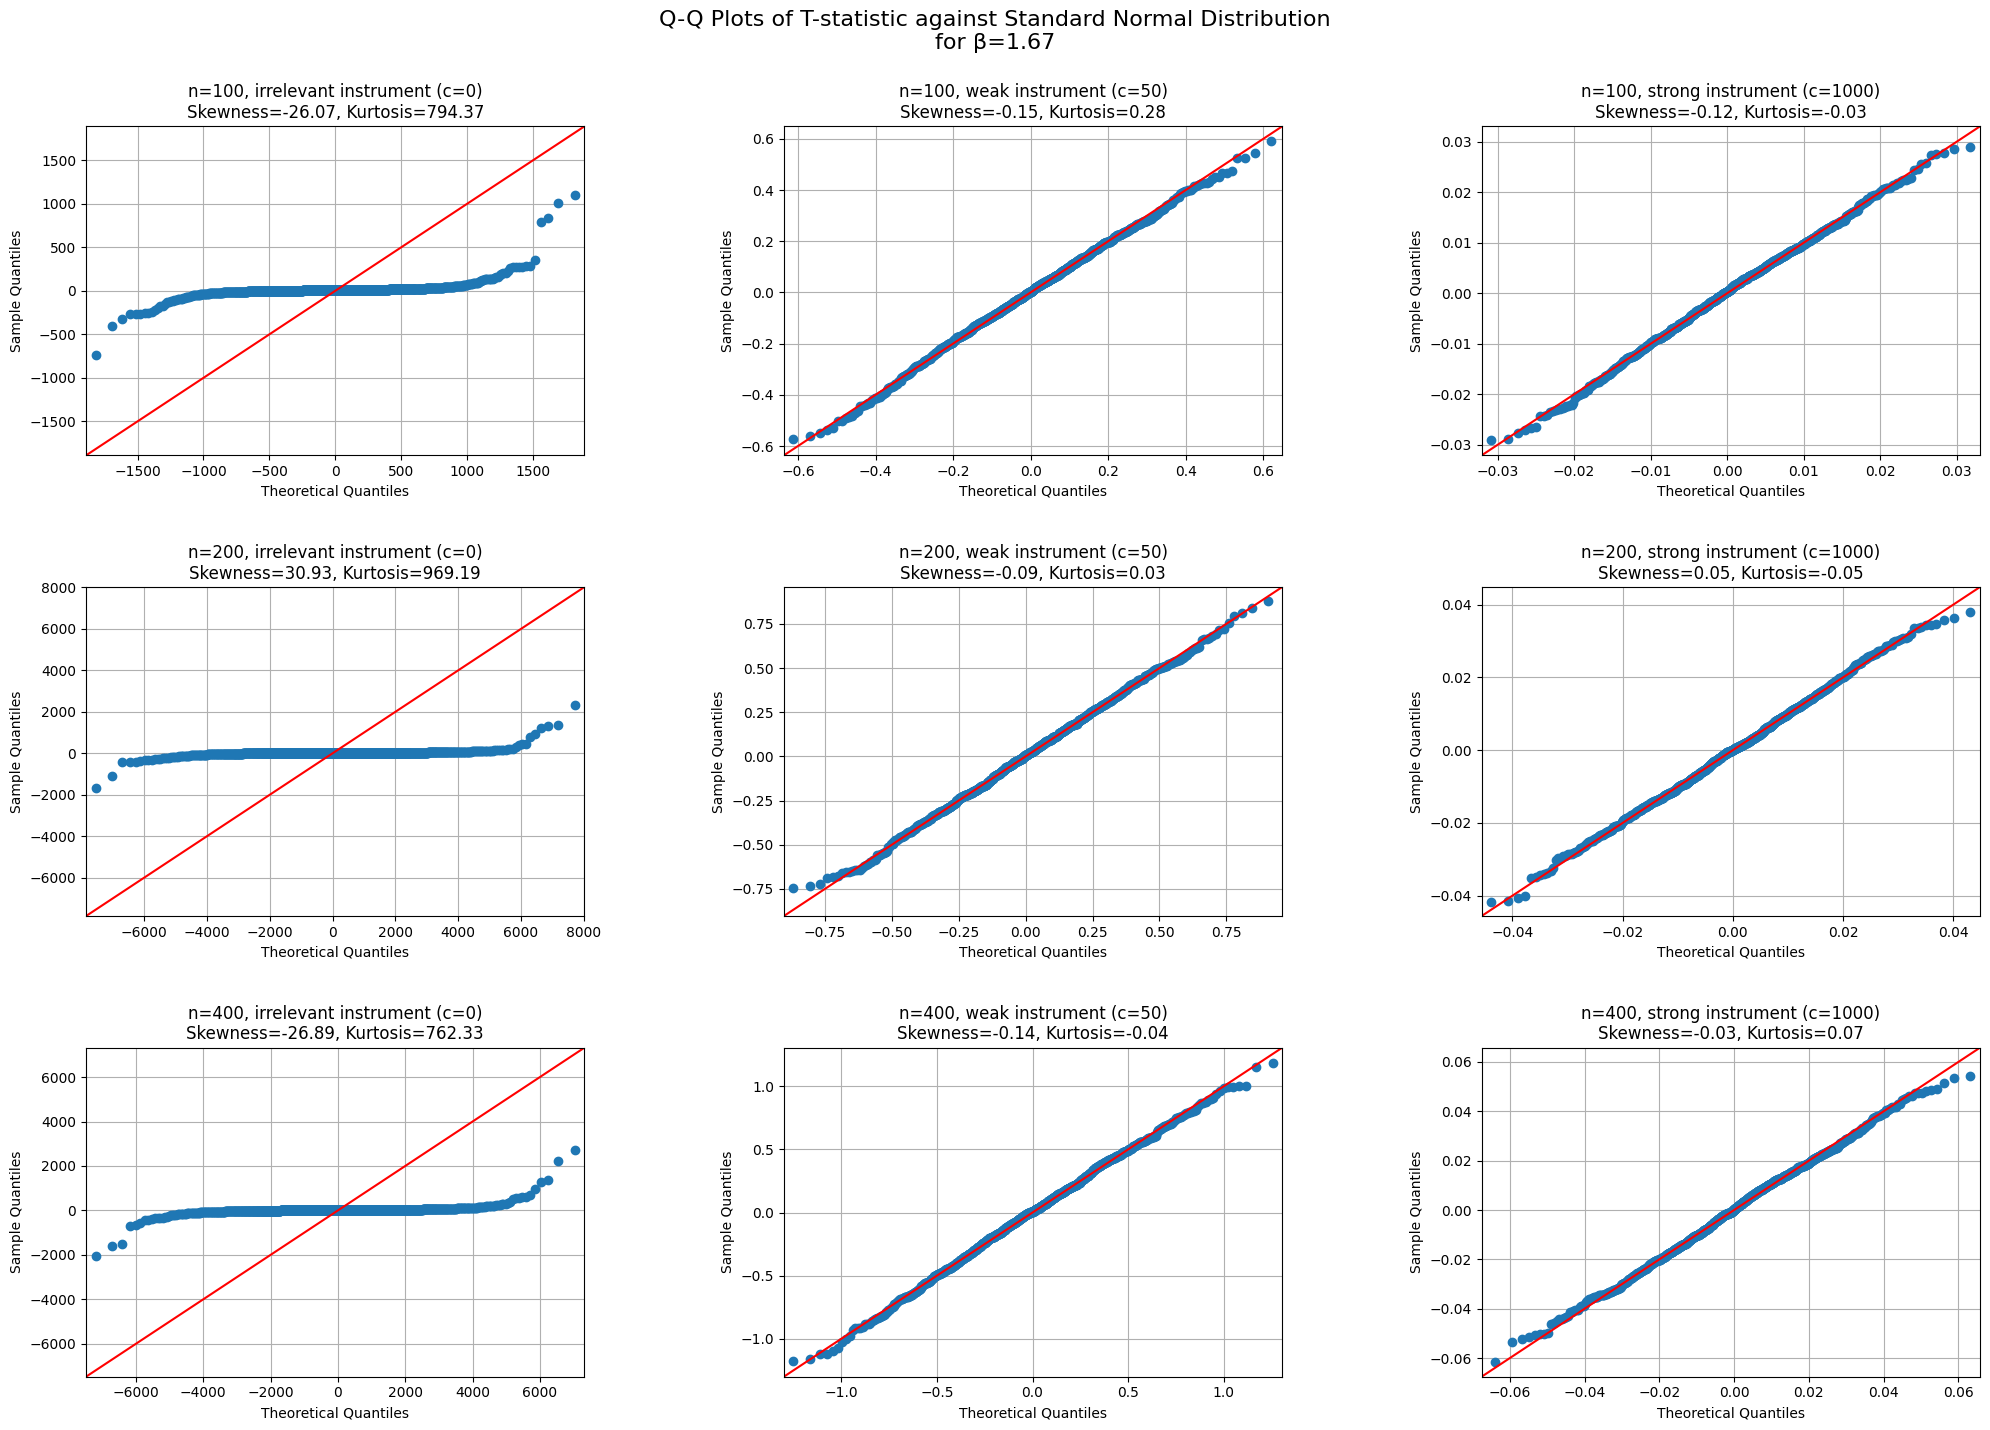

In [ ]:
# --- DESCRIPTION OF NON-NORMALITY (without bootstrap) ---

# We create QQ plots and compute skewness and kurtosis
# for each combination of sample size, instrument relevance
# keeping beta fixed at 1.67

# Plot the Q-Q plot for each combination of sample size and instrument relevance
fig, axs = plt.subplots(len(sample_sizes), len(c_array), figsize=(20, 15))

for i, n in enumerate(sample_sizes):
    for j, c in enumerate(c_array):
        # Filter the data for the current sample size and instrument relevance
        subset = MC_results_sample_df[(MC_results_sample_df['n'] == n) & (MC_results_sample_df['pi'] == c / np.sqrt(n))]

        # Extract the t_star values
        t_values = subset['t_statistic'].values

        # Extract instrument relevance
        inst_relevance = subset['instrument_relevance'].values[0]

        # Calculate skewness and kurtosis
        skewness = skew(t_values)
        kurt = kurtosis(t_values)

        # Remove outliers using Z-score method
        z_scores = zscore(t_values)
        t_filtered = t_values[(z_scores > -3) & (z_scores < 3)]

        # Q-Q plot against standard normal distribution
        sm.qqplot(t_filtered, line='45', dist=norm, ax=axs[i, j], loc=np.mean(t_values), scale=np.std(t_values))
        axs[i, j].set_title(f'n={n}, {inst_relevance} instrument (c={c})\nSkewness={skewness:.2f}, Kurtosis={kurt:.2f}')
        axs[i, j].grid(True)

# Set an overall title for the figure
fig.suptitle(f'Q-Q Plots of T-statistic against Standard Normal Distribution\nfor β={beta_value:.2f}', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to make room for the overall title
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Increase space between plots
plt.show()

### Question 6

In [ ]:
# --- PRODUCE DATA ---

# Set random seed for reproducibility
np.random.seed(42)

# --- Parameters ---

# We redefine the parameters for the bootstrap procedure
beta_value = beta_value  # we choose again a value 1.67 for beta for illustrative purposes
c_array_new = [0, 50, 100, 1000] # possible values for the numerator of pi
sample_size = 100
m = sample_size # number of bootstrap replications
n_samples = 4 # number of samples to generate

# --- Bootstrap procedure ---

# We generate 4 samples for each possible value of c

# At each iteration we store the t_star statistic
# (standardized by the standard error of beta_hat as in the last formula of page 3)

# We simulate the procedure 1000 times to obtain a larger sample of t_star statistics

results_six = [] # list to store the results

# initialize categorical variable for instrument relevance
inst_relevance = None

# Calculate the total number of iterations
total_iterations = len(c_array_new) * n_samples * MC_rep
current_iteration = 0

# Loop over the possible values of c

for c in c_array_new:
    # label the instrument relevance
    if c == 0:
        inst_relevance = 'irrelevant'
    elif c == 50:
        inst_relevance = 'weak'
    elif c == 100:
        inst_relevance = 'moderate'
    elif c == 1000:
        inst_relevance = 'strong'

    for i in range(MC_rep): # run 1000 simulations
        for s in range(n_samples): # generate 4 samples
            # Generate the data
            y, x, z = generate_data(n, c, beta_value, sigma_eps, sigma_u, sigma_z, cov_eps_u)

            # Draw the original sample and estimate the parameters
            beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

            # Bootstrap the data
            t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat, boot_rep=m)[0]

            # Store the results
            results_six.append({
                'c': c,
                'pi': c / (n**0.5),
                'instrument_relevance': inst_relevance,
                't_star': t_star
            }) # create a Dataframe with computed t_star

            # Update and print state of the simulation
            current_iteration += 1
            total_completion = (current_iteration / total_iterations) * 100
            print(f"Completion of bootstrap: {total_completion:.2f}%")

# Store the results in a DataFrame
results_six = pd.DataFrame(results_six)

Output streaming troncato alle ultime 5000 righe.
Completion of bootstrap: 68.76%
Completion of bootstrap: 68.76%
Completion of bootstrap: 68.77%
Completion of bootstrap: 68.77%
Completion of bootstrap: 68.78%
Completion of bootstrap: 68.79%
Completion of bootstrap: 68.79%
Completion of bootstrap: 68.80%
Completion of bootstrap: 68.81%
Completion of bootstrap: 68.81%
Completion of bootstrap: 68.82%
Completion of bootstrap: 68.83%
Completion of bootstrap: 68.83%
Completion of bootstrap: 68.84%
Completion of bootstrap: 68.84%
Completion of bootstrap: 68.85%
Completion of bootstrap: 68.86%
Completion of bootstrap: 68.86%
Completion of bootstrap: 68.87%
Completion of bootstrap: 68.88%
Completion of bootstrap: 68.88%
Completion of bootstrap: 68.89%
Completion of bootstrap: 68.89%
Completion of bootstrap: 68.90%
Completion of bootstrap: 68.91%
Completion of bootstrap: 68.91%
Completion of bootstrap: 68.92%
Completion of bootstrap: 68.92%
Completion of bootstrap: 68.93%
Completion of bootstra

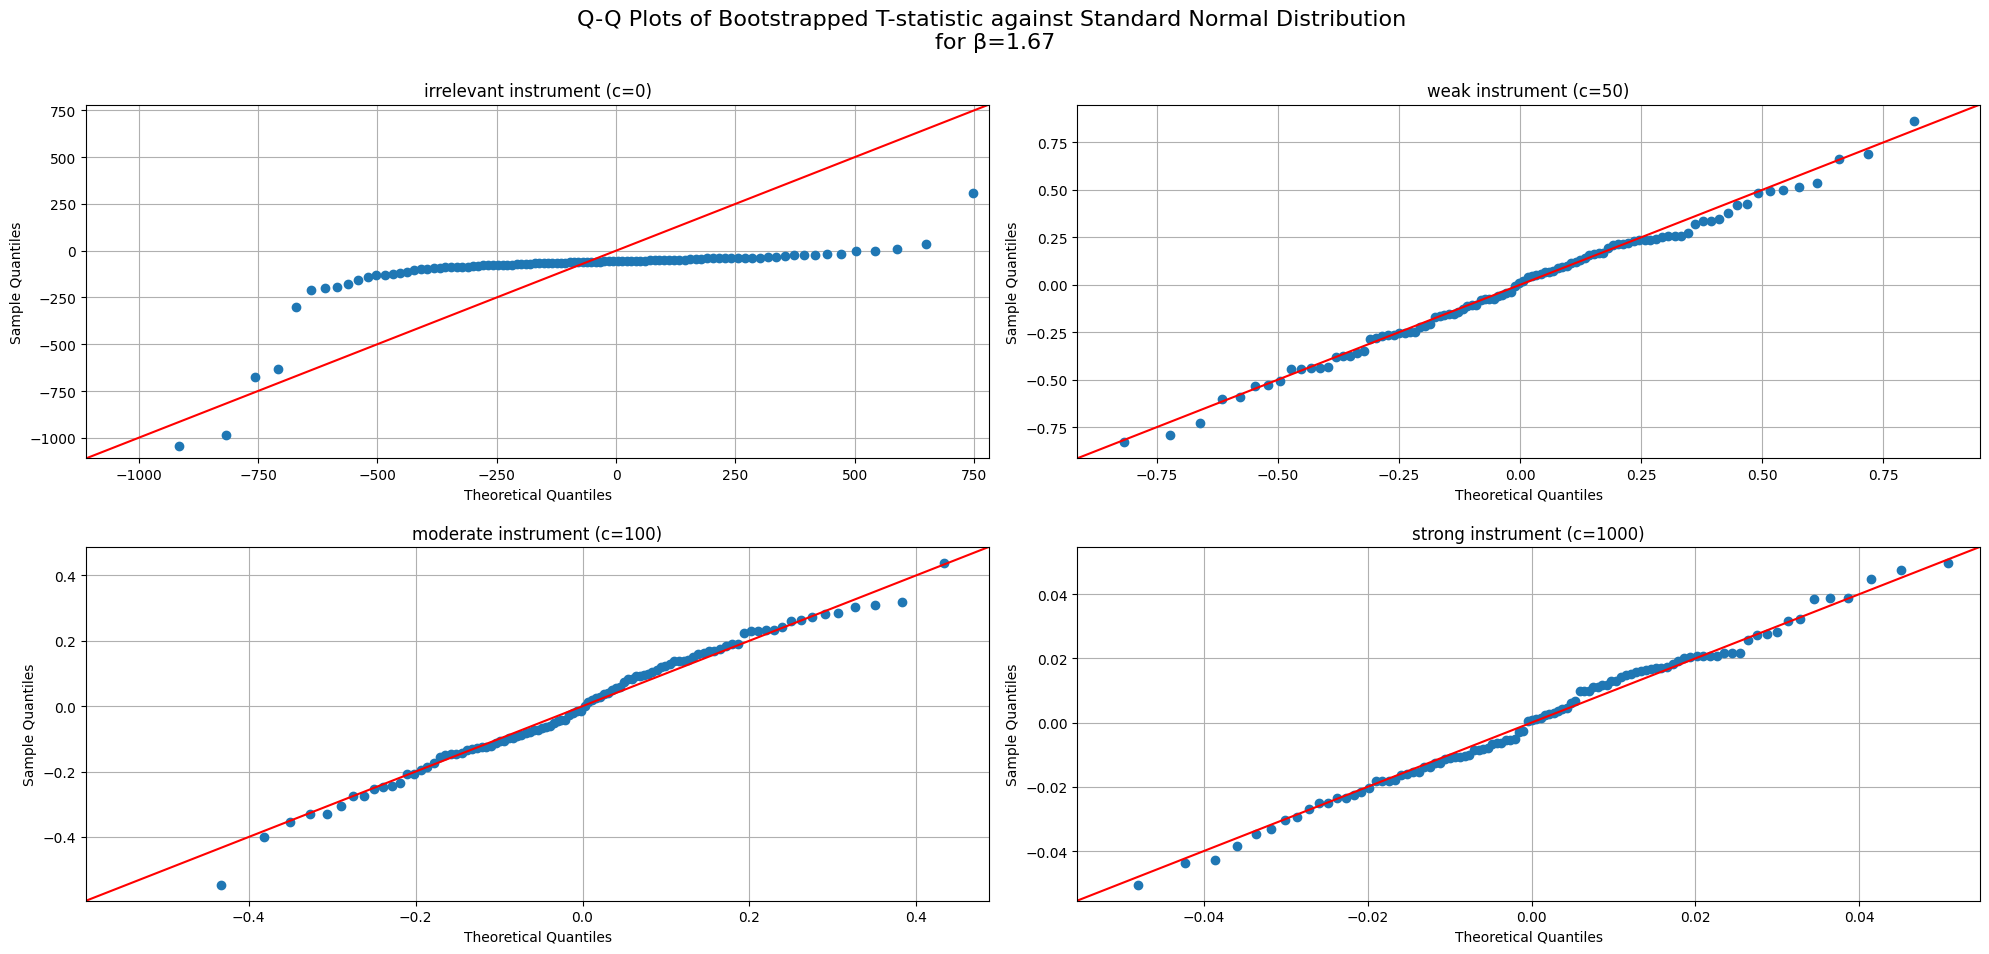

In [ ]:
# --- QQ PLOTS ---

# Plot the Q-Q plot for each value of inst_relevance in results_six

fig_qq, axs_qq = plt.subplots(2, 2, figsize=(20, 10))

for i, c in enumerate(c_array_new):
    # Extract t_star values for the current pi_value
    subset_t_star = results_six[results_six['c'] == c]['t_star'].values[0]
    inst_relevance = results_six[results_six['c'] == c]['instrument_relevance'].values[0]

    # Remove outliers using Z-score method
    z_scores = zscore(subset_t_star)
    subset_t_star_filtered = subset_t_star[(z_scores > -3) & (z_scores < 3)]

    # Q-Q plot against standard normal distribution
    sm.qqplot(subset_t_star_filtered, line='45', dist=norm, ax=axs_qq[i // 2, i % 2], loc=np.mean(subset_t_star), scale=np.std(subset_t_star))
    axs_qq[i // 2, i % 2].set_title(f'{inst_relevance} instrument (c={c})')
    axs_qq[i // 2, i % 2].grid(True)

# Set an overall title for the figure
fig_qq.suptitle(f'Q-Q Plots of Bootstrapped T-statistic against Standard Normal Distribution \nfor β={beta_value:.2f}', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to make room for the overall title
plt.subplots_adjust(hspace=0.25)   # Increase hspace to add more vertical space
plt.show()

### Question 7

In [ ]:
# --- MONTECARLO SIMULATION (with bootstrap)---

# Set random seed for reproducibility
np.random.seed(42)

# We simulate the bootstrap procedure
# for each combination of sample size, c, and beta for MC_rep times
# and store the results of the Shapiro-Wilk test on the t_statistic
# (i.e., the t_star standardized by the standard error of beta_hat as in the last formula of page 3)

MC_rep = 1000 # number of MonteCarlo simulations
MC_results = [] # store the results of the MonteCarlo simulation

inst_relevance = None

# Debugging line
# Calculate the total number of iterations
# to print the state of the simulation during the loop
# total_iterations = len(sample_sizes) * len(c_array) * len(beta_array) * MC_rep
# current_iteration = 0

# Loop over the combinations of sample size, c, and beta
for n in sample_sizes:

    for c in c_array:
        # label the instrument relevance
        if c == 0:
            inst_relevance = 'irrelevant'
        elif c == 50:
            inst_relevance = 'weak'
        elif c == 1000:
            inst_relevance = 'strong'

        for beta in beta_array:

            for i in range(MC_rep):
                # Generate the data
                y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)

                # Draw the original sample and estimate the parameters
                beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

                # Bootstrap the data
                t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0] # use default value for boot_rep

                # Run the Shapiro-Wilk test on t_star
                shapiro_result = shapiro(t_star)
                statistic = round(shapiro_result.statistic, 4)
                pvalue = round(shapiro_result.pvalue, 4)
                reject_5 = pvalue < 0.05
                reject_1 = pvalue < 0.01

                # Store the results
                MC_results.append({
                    'n': n,
                    'pi': c / (n**0.5),
                    'instrument_relevance': inst_relevance,
                    'beta': beta,
                    't_star': t_star,
                    'statistic': statistic,
                    'pvalue': pvalue,
                    'reject_5': reject_5,
                    'reject_1': reject_1
                }) # create a Dataframe indexed by n, pi=c/sqrt(n), beta, with as columns the results of the test

                # Debugging line
                # Update and print state of the simulation
                # current_iteration += 1
                # total_completion = (current_iteration / total_iterations) * 100
                # print(f"Completion of Monte Carlo: {total_completion:.2f}%")

# Create a DataFrame to store the results
MC_results_df = pd.DataFrame(MC_results)

Streaming output truncated to the last 5000 lines.
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.45%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.46%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.47%
Completion of Monte Carlo: 94.4

In [ ]:
# --- REJECTION FREQUENCIES ---
# Using the Data Frame MC_results_df we generate rejection frequencies

# Compute statistics (mean and std) and rejection frequencies
summary_df = MC_results_df.groupby(['n', 'instrument_relevance', 'beta']).agg(
    pvalue_mean=('pvalue', 'mean'),
    rejection_freq_5_percent=('reject_5', 'mean'),
    rejection_freq_1_percent=('reject_1', 'mean')
).reset_index()

# Convert pvalue_mean, rejection_freq_5_percent, and rejection_freq_1_percent to percentage and round to the second decimal
summary_df['pvalue_mean'] = (summary_df['pvalue_mean'] ).round(2)
summary_df['rejection_freq_5_percent'] = (summary_df['rejection_freq_5_percent'] * 100).round(2)
summary_df['rejection_freq_1_percent'] = (summary_df['rejection_freq_1_percent'] * 100).round(2)

summary_df.columns = [
    'Sample size', 'Instrument relevance', 'β', 'Mean p-value', 'Rejection frequency at 5%', 'Rejection frequency at 1%'
]

instrument_relevance_order = CategoricalDtype(
    ['irrelevant', 'weak', 'strong'],
    ordered=True
)

summary_df['Instrument relevance'] = summary_df['Instrument relevance'].astype(instrument_relevance_order)

# Set multilevel index
summary_df.set_index(['Sample size', 'Instrument relevance', 'β'], inplace=True)

summary_df.sort_index(level=['Sample size', 'Instrument relevance', 'β'], inplace=True)

# Highlighting function for values
def highlight_rejection(val):
    if val >= 99:
        return 'background-color: lightcoral;'  # Light orange
    elif val >= 90:
        return 'background-color: lightyellow;'  # Light yellow
    return ''

# Define caption
caption_html = """
    <b style="font-size: larger;">Shapiro-Wilk Normality test: Monte Carlo simulation summary</b><br>
    <i>1000 MC replications; bootstrapping with m=n<sup>4/5</sup></i><br>
    <i>yellow cells = rejection frequency &gt; 90%; red cells = rejection frequency &gt; 99%.</i>
"""

# Combine both highlighting and borders
styled_df = (summary_df
    .style
    .map(highlight_rejection, subset=['Rejection frequency at 5%', 'Rejection frequency at 1%'])
    .set_caption(caption_html)

)

# Format all cells inside table body to have 2 decimal places
styled_df = styled_df.format(precision=2)

# Format the 'β' index to have 2 decimal places
styled_df = styled_df.format_index(level='β', precision=2)

# Generate the list of styles
step = len(beta_array)
total_steps = len(sample_sizes) * len(c_array) * len(beta_array)

styles = []

for i in range(0, total_steps, step):
    styles.append({
        'selector': f'tbody tr:nth-child(n+{1+i}):nth-child(-n+{i+step})',
        'props': [
            ('border', '1px solid black')
        ]
    })

# Set table styles collectively
styled_df = styled_df.set_table_styles(styles)

# Display the styled DataFrame
styled_df

#dfi.export(styled_df, 'full_table_question_7.png', max_rows=-1, max_cols=-1, dpi=300)

In [ ]:
# Export a smaller table, focusing on beta = 1.67 for illustration purposes

include_values = [beta_array[7]]

small_summary_df = summary_df.loc[summary_df.index.get_level_values('β').isin(include_values)]
small_summary_df.drop(columns='Rejection frequency at 1%', inplace=True)


# Combine both highlighting and borders
small_styled_df = (small_summary_df
    .style
    .map(highlight_rejection, subset=['Rejection frequency at 5%'])
    .set_caption(caption_html)
)

# Format all cells inside table body to have 2 decimal places
small_styled_df = small_styled_df.format(precision=2)

# Format the 'β' index to have 2 decimal places
small_styled_df = small_styled_df.format_index(level='β', precision=2)

# Generate the list of styles
step = len(beta_array)
total_steps = len(sample_sizes) * len(c_array) * len(beta_array)

styles = []

for i in range(0, total_steps, step):
    styles.append({
        'selector': f'tbody tr:nth-child(n+{1+i}):nth-child(-n+{i+step})',
        'props': [
            ('border', '1px solid black')
        ]
    })

# Set table styles collectively
small_styled_df = small_styled_df.set_table_styles(styles)

# Display the styled DataFrame
small_styled_df

# Export to png
#dfi.export(small_styled_df, 'small_table_question_7.png', max_rows=-1, max_cols=-1, dpi=300)

<ipython-input-38-d45f715e6767>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_summary_df.drop(columns='Rejection frequency at 1%', inplace=True)


### Question 8

In [ ]:
# --- QUESTION 8 ---

# Define a function to compute \hat{d}_n
# Given bootstrap t_star and a significance level alpha
def compute_dn(t_star, x_min=1.96, x_max=5, num_points=1000):

    # Compute the empirical CDF
    G_hat = ECDF(t_star)

    # Create a grid of x values from x_min to x_max
    x_values = np.linspace(x_min, x_max, num_points)

    # Compute the absolute differences |G_hat(x) - Phi(x)|
    differences = np.abs([G_hat(x) - norm.cdf(x) for x in x_values])

    # Return the supremum of the differences
    return np.max(differences)

# Generate the null distribution for d_n

def generate_null_distribution(n, MC_rep=1000):
    d_n_values = []
    m = round(n**(4/5)) # number of bootstrap replications

    for _ in range(MC_rep):
        # Generate m boostrap samples from a normal(0,1) distribution
        bootstrap_samples = np.random.normal(0, 1, m)

        # Compute \hat{d}_n for this replication
        d_n = compute_dn(bootstrap_samples)
        d_n_values.append(d_n)

    return np.array(d_n_values)

# Calculate the critical value for \hat{d}_n
def calculate_critical_value(n, MC_rep=1000, alpha=0.05):
    null_d_n = generate_null_distribution(n, MC_rep)
    critical_value = np.percentile(null_d_n, 100 * (1 - alpha))
    return critical_value

In [ ]:
# --- SIMULATION ---

beta_value = beta_array[7]  # we choose again a value 1.67 for beta for illustrative purposes
MC_rep = 100  # Number of Monte Carlo simulations
critical_values = []  # Store critical values
results_combined = []

# Debugging lines to compute the total number of iterations in the loop
# total_iterations = len(sample_sizes) * len(c_array) * MC_rep
# current_iteration = 0

for n in sample_sizes:
    # Generate null distribution and critical value for \hat{d}_n
    critical_value = calculate_critical_value(n, MC_rep=MC_rep, alpha=0.05)
    critical_values.append({'Sample size': n, 'Critical value': critical_value})

    for c in c_array:
        inst_relevance = 'irrelevant' if c == 0 else 'weak' if c == 50 else 'strong'

        for _ in range(MC_rep):
            # Generate the data
            y, x, z = generate_data(n, c, beta_value, sigma_eps, sigma_u, sigma_z, cov_eps_u)

            # Estimate parameters
            beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

            # Bootstrap the data
            t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0]

            # Compute \hat{d}_n
            d_n = compute_dn(t_star)

            # Check if \hat{d}_n exceeds the critical value
            reject = d_n > critical_value

            # Store the result
            results_combined.append({
                'Sample size': n,
                'Instrument relevance': inst_relevance,
                'Beta': beta_value,
                'd_n': d_n,
                'Reject': reject
            })

            # Debugging lines
            # Update and print state of the simulation
            # current_iteration += 1
            # total_completion = (current_iteration / total_iterations) * 100
            # print(f"Completion of bootstrap: {total_completion:.2f}%")

# Convert results to DataFrame
critical_values_df = pd.DataFrame(critical_values)
results_combined_df = pd.DataFrame(results_combined)

In [ ]:
# --- PRINTING RESULTS ---

# Summarize rejection frequencies

# Compute statistics and rejection frequencies
summary_combined = results_combined_df.groupby(['Sample size', 'Instrument relevance', 'Beta']).agg(
    Mean_d_n=('d_n', 'mean'),
    Rejection_Frequency=('Reject', 'mean')
).reset_index()

# Convert frequencies to percentages
summary_combined['Rejection_Frequency'] = (summary_combined['Rejection_Frequency'] * 100).round(2)

# Style and display the results
summary_combined.columns = [
    'Sample size', 'Instrument relevance', 'β', 'Mean d_n', 'Rejection frequency (%)'
]
summary_combined.set_index(['Sample size', 'Instrument relevance', 'β'], inplace=True)
summary_combined.sort_index(level=['Sample size', 'Instrument relevance', 'β'], inplace=True)

# Define a highlighting function
def highlight_rejection(val):
    if val > 70:
        return 'background-color: lightcoral;'  # Red for high rejection
    elif val > 50:
        return 'background-color: lightyellow;'  # Yellow for moderate rejection
    return ''

# Style the DataFrame
styled_summary_combined = (
    summary_combined.style
    .applymap(highlight_rejection, subset=['Rejection frequency (%)'])
    .format(precision=2)
    .set_caption(
        "<b>Rejection Frequencies </b><br>"
        "<i>100 MC replications; bootstrap-based critical values.</i>"
    )
)

# Display the styled DataFrame
styled_summary_combined

# Export to png
# dfi.export(styled_summary_combined, 'rejection_table_question_8.png', max_rows=-1, max_cols=-1, dpi=300)

<ipython-input-16-5a481bf52941>:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary_combined.style


In [ ]:
# Display the table with critical values
critical_values_df

# Export to png
# dfi.export(critical_values_df, 'critical_values_question_8.png', max_rows=-1, max_cols=-1, dpi=300)

,Sample size,Critical value
0,100,0.050088
1,200,0.037966
2,400,0.027396


### Question 9